# MAC0318 - Aprendizado Supervisionado - Notebook 2

*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e as bibliotecas NumPy e Tensorflow instaladas. Se você não conseguir ou quiser instalar o Tensorflow em seu computador, é possível rodá-lo na nuvem usando o [Google Colab](colab.research.google.com), como descrito na respectiva seção abaixo. 
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter e conhecimentos básicos de redes neurais e aprendizado por descida de gradiente. Recomendamos seguir algum tutorial da internet antes de realizar essa atividade, se esse não for o seu caso.

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckietown` do conda antes de abrir o jupyter notebook e escolher o kernel `duckietown`, para que os requerimentos sejam satisfeitos.</red>

## Estimando a localização do robô na pista

Nessa atividade, você vai construir um modelo baseado em redes neurais (densas) que usa a imagem da câmera frontal do robô para prever a distância ($d$) e a inclinação ($\alpha$) relativas ao centro da pista, como mostrados na figura abaixo.

<figure style="text-align: center">
    <img src="img/lane_following2.png" width=300>
</figure>

Tais medidas poderiams ser usadas para controlar a posição do robô e fazê-lo permanecer dentro da pista, usando um algoritmo de controle como vimos anteriomente.
Para simplificar a tarefa, vamos considerar um valor agregado das medidas, dado por:

$$
y(t) = 6d(t) + \alpha(t) .
$$

Esse valor será nosso alvo, ou seja, o que queremos prever baseado em uma imagem da câmera. 

## Pré-processamento da imagem

Vamos primeiro redimensionar as imagens e aplicar filtros de segmentação de cores nas imagens para simplificar o problema de aprendizado subsequente.

In [1]:
# Começamos carregando as bibliotecas necessárias

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import cv2
import gc

2025-10-08 17:26:15.618023: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 17:26:15.662272: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 17:26:15.662971: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 17:26:16.318362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Obtendo o conjunto de dados

O processo de construção de um sistema baseado em aprendizado começa pela aquisição e anotação (rotulação) dos dados, ou seja, um conjunto de exemplos de pares entrada e saída, $x_i,y_i$. Para sua conveniência, disponibilizamos um conjunto de dados de imagens de captura da camêra simulada (no duckietown) do agente (entrada) anotadas com os respectivos valores de saída $y=6d+\alpha$ (saída).

Baixe os arquivos `data-lane-pose-estimation-images.npy` [nesse link](https://drive.google.com/file/d/1n9uitBceCk4xXEJ7njoKWFMXpNegySDQ/view?usp=sharing) e `data-lane-pose-estimation-labels.npy` [nesse link](https://drive.google.com/file/d/1yVujNH-Hd7ifqKrgAe6XscawdhDVkn_f/view?usp=sharing) e os salve na mesma pasta que esse notebook (ou modifique o nome do arquivo na célula seguinte).

O primeiro arquivo contém as imagens e o segundo arquivo contém as anotações de valores da saída. De forma a diminuir o tamanho do arquivo, as imagens foram preprocessadas para cortar a parte da imagem acima da linha do horizonte e redimensionadas.

In [2]:
# Mude os endereços dos arquivos conforme necessário
images = np.load('data-lane-pose-estimation-images.npy', allow_pickle=True) 
print('Dimensões das imagens:', images.shape) # dimensões do conjunto de imagens: número de exemplos e dimensões de cada imagem
y_true = np.load('data-lane-pose-estimation-labels.npy', allow_pickle=True) 
print('Dimensões das saídas:', y_true.shape) # dimensões do conjunto de saídas: número de exemplos

Dimensões das imagens: (3775, 42, 80, 3)
Dimensões das saídas: (3775,)


Vamos ver a primeira imagem do conjunto e suas saída

Dimensões: 80x42 pixels


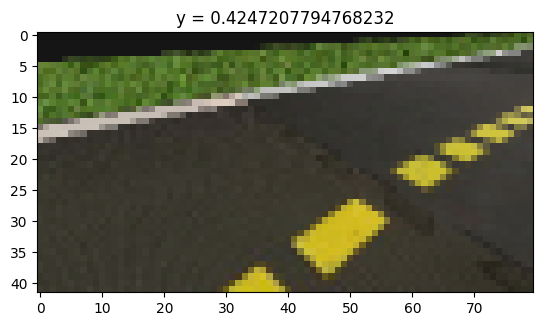

In [3]:
img, y = images[0], y_true[0]
plt.imshow(img);
plt.title(f'y = {y}')
print(f'Dimensões: {img.shape[1]}x{img.shape[0]} pixels')

Vamos visualizar algumas da imagens

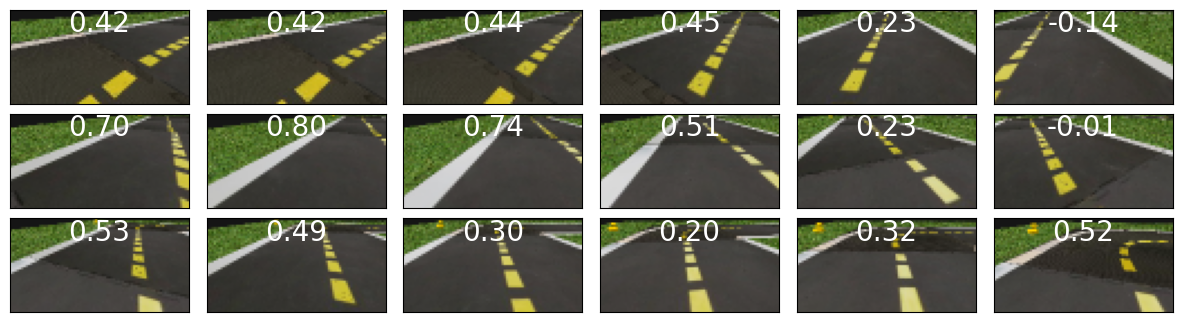

In [4]:
num_rows, num_cols =  3, 6
aspect_ratio = img.shape[1]/img.shape[0]
fig_width = 15
fig, ax = plt.subplots(num_rows,num_cols,figsize=(fig_width,fig_width*(num_rows/num_cols)/aspect_ratio))
for i in range(num_rows):
    for j in range(num_cols):
        k = 7*(10*i + j) # modifique a constante inicial 7 para mudar as imagens mostradas
        ax[i,j].imshow(images[k]);
        ax[i,j].annotate(f'{y_true[k]:.2f}', 
                         xy=(0.5, 0.85), 
                         xycoords='axes fraction',
                         va="center", ha="center",
                         color='white',
                         fontsize=20)
        ax[i,j].tick_params(   # remover rótulos de eixos, gradações etc
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
fig.subplots_adjust(wspace=0.1, hspace=0.1)

Vamos analizar a distribuição dos valores de saída -- Idealmente, gostaríamos de encontrar uma distribuição simétrica, próxima da uniforme, e com suporte que cobrisse uma gama significativa dos valores de saída que esperamos encontrar na prática. Dessa maneira, garantimos que nosso estimador funcionará bem quando colocado em uso.

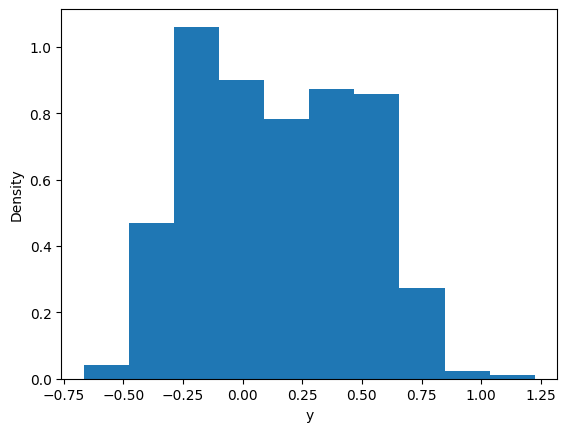

In [5]:
plt.hist(y_true, density=True);
plt.xlabel('y');
plt.ylabel('Density');

### Segmentação por cor

Para simplificar o problema, vamos segmentar as imagens pelas cores amarela e branca com um filtro de intervalo no espaço HSV, e representar as segmentações em canais distintos.

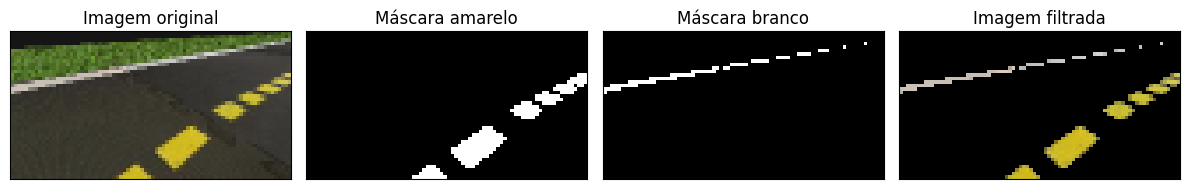

In [6]:
# Intervalo para cor amarela 
amarelo_i = np.array([10, 80, 100], dtype=np.uint8)  # limite inferior
amarelo_s = np.array([30, 255, 255], dtype=np.uint8) # limite superior

# Intervalo para cor branca
branco_i = np.array([0, 0, 180], dtype=np.uint8)    # limite inferior
branco_s = np.array([179, 80, 255], dtype=np.uint8) # limite superior

# obter representação HSV
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
# Construir máscara dos pontos no hiperretângulo do espaço HSV especificado para cor amarela
mask_a = cv2.inRange(hsv, amarelo_i, amarelo_s)
# Construir máscara dos pontos no hiperretângulo do espaço HSV especificado para cor branca
mask_b = cv2.inRange(hsv, branco_i, branco_s)
# Combinar máscaras e imagem original para visualização
masked = cv2.bitwise_and(img[:,:,:3], img[:,:,:3], mask=(mask_a + mask_b))
# Mostrar resultado da segmentação
f, ax = plt.subplots(1,4, figsize=(12,5))
ax[0].imshow(img);
ax[0].set_title('Imagem original');
ax[1].imshow(mask_a, cmap='gray');
ax[1].set_title('Máscara amarelo');
ax[2].imshow(mask_b, cmap='gray');
ax[2].set_title('Máscara branco');
ax[3].imshow(masked[:,:,:3]);
ax[3].set_title('Imagem filtrada');
# Vamos remover as anotações dos exisos para melhorar a visualização
for i in range(4):
    ax[i].tick_params(
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
plt.tight_layout();

Aplicamos a segmentação ao conjunto inteiro, criando um novo conjunto de imagens. Vamos aproveitar também para reduzir o tamanho das imagens de forma a diminuir o uso de memória e de processamento no aprendizado. O código abaixo reduz em 1/3 a imagem, mas você pode aplicar reduções maiores (por exemplo, 1/5) se necessário.

In [7]:
# Criamos uma matriz N x A x L x 2 para guardar N imagens com 2 canais (amarelo e branco), 
# onde L e A são as dimensões de uma imagem (largura e altura)
X = np.zeros((images.shape[0], images.shape[1], images.shape[2], 2), dtype=np.float32)
# Agora segmentamos cada imagem e separamos os canais
for i in range(images.shape[0]):
    # obter representação HSV
    hsv = cv2.cvtColor(images[i,:,:,:], cv2.COLOR_RGB2HSV)
    # Construir máscara dos pontos no hiperretângulo do espaço HSV especificado para cor amarela
    X[i,:,:,0] = cv2.inRange(hsv, amarelo_i, amarelo_s)//255 # dividimos por 255 para normalizar a saída em [0,1], o que é melhor para o aprendizado
    # Construir máscara dos pontos no hiperretângulo do espaço HSV especificado para cor branca
    X[i,:,:,1] = cv2.inRange(hsv, branco_i, branco_s)//255

Vamos visualizar o resultado (as cores não são importantes, pois estamos apenas representando as máscaras amarelo e branca)

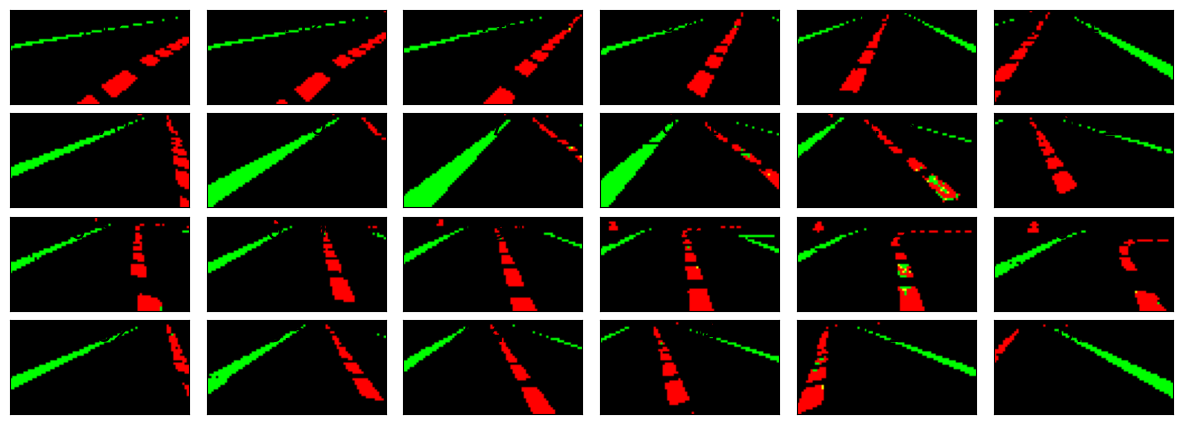

In [8]:
num_rows, num_cols =  4, 6
aspect_ratio = X.shape[2]/X.shape[1]
fig_width = 15
fig, ax = plt.subplots(num_rows,num_cols,figsize=(fig_width,fig_width*(num_rows/num_cols)/aspect_ratio))
for i in range(num_rows):
    for j in range(num_cols):
        k = 7*(10*i + j) # modifique a constante inicial 10 para mudar as imagens mostradas
        # vamos criar uma imagem com 3 canais apenas para poder exibir em cores
        image = np.zeros((X.shape[1],X.shape[2],3), dtype=np.float32) 
        image[:,:,:2] = X[k,:,:,:]
        ax[i,j].imshow(image);
        ax[i,j].annotate(f'{y_true[k]:.2f}', 
                         xy=(0.5, 0.85), 
                         xycoords='axes fraction',
                         va="center", ha="center",
                         color='black',
                         fontsize=20)
        ax[i,j].tick_params(   # remover rótulos de eixos, gradações etc
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
fig.subplots_adjust(wspace=0.1, hspace=0.1)

## Separação treino-teste-validação

Os dados que temos servem três propósitos distintos:

1. **Treino**: Selecionar ou ajustar os parâmetros do modelo para obter uma acurácia alta.
2. **Validação**: Comparar e escolher entre diferentes hipóteses (por exemplo, valores de hiperparâmetros como arquiterura da rede, taxa e algoritmo de aprendizado etc) e configurações
3. **Teste**: Estimar a acurácia do modelo em dados reais *não vistos*

Esses propósitos são por vezes contraditórios. Por exemplo, na etapa de treino desejamos escolher a configuração que maximiza a acurácia do modelo. Já na etapa de teste, queremos avaliar se tal acurácia é realista com relação à população de dados. De forma similar, se usarmos os mesmos dados para o treino e validação, corremos o risco de superestimar a qualidade de uma hipótese. A solução é separar os dados em três conjuntos, cada qual servindo a uma das etapas acima. Vamos adotar a heurística de divisão 80/20 que separa aproximadamente 80% dos dados para treino e validação e 20% para teste. Vamos ver mais adiante que usaremos uma metodologia de validação que usa amostras do conjunto de teste. Também permutamos a ordem das imagens para remover qualquer relação temporal, o que afetaria o desempenho do aprendizado.

In [9]:
p = 0.8 # proporção do tamanho dp subconjunto de treino
N_treino = int(p*X.shape[0] + 0.5) # quantidade de exemplos de treino

# Permutamos os índices dos exemplos
indices = np.random.permutation(X.shape[0])
id_treino, id_teste = indices[:N_treino], indices[N_treino:]
X_treino, X_teste = X[id_treino,:,:,:], X[id_teste,:,:,:]
y_treino, y_teste = y_true[id_treino], y_true[id_teste]

print(f'Proporção de treino: {X_treino.shape[0]/X.shape[0]:.4f}')

Proporção de treino: 0.8000


Vamos visualizar os dados para nos assegurar -- além de notar a consitência entre o rótulo (o valor $y$) e a imagem, as imagens devem ser de poses distintas.

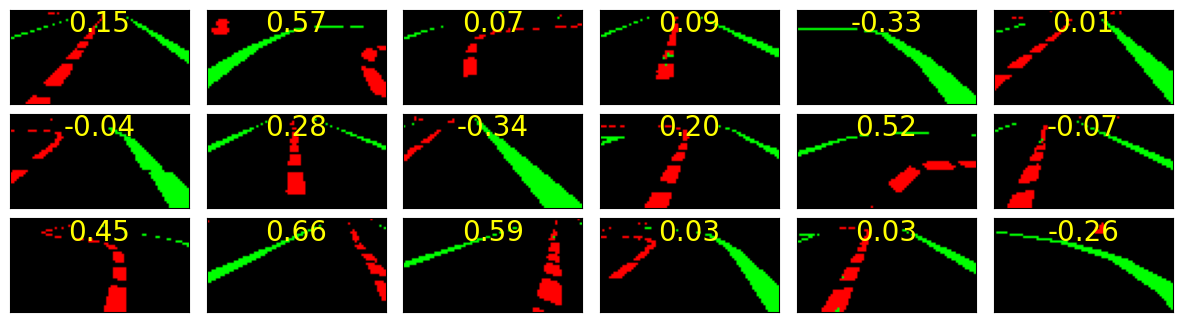

In [10]:
num_rows, num_cols =  3, 6
aspect_ratio = X_treino[0].shape[1]/X_treino[0].shape[0]
fig_width = 15
fig, ax = plt.subplots(num_rows,num_cols,figsize=(fig_width,fig_width*(num_rows/num_cols)/aspect_ratio))
for i in range(num_rows):
    for j in range(num_cols):
        k = 10*i + j 
        image = np.zeros((X_treino.shape[1],X_treino.shape[2],3), dtype=np.float32)
        image[:,:,:2] = X_treino[k,:,:,:]        
        ax[i,j].imshow(image);
        ax[i,j].annotate(f'{y_treino[k]:.2f}', 
                         xy=(0.5, 0.85), 
                         xycoords='axes fraction',
                         va="center", ha="center",
                         color='yellow',
                         fontsize=20)
        ax[i,j].tick_params(   # remover rótulos de eixos, gradações etc
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,         
            left=False,        
            labelleft=False,   
            labelbottom=False) 
fig.subplots_adjust(wspace=0.1, hspace=0.1)

##  Treinamento

Podemos finalmente aprender uma rede neural para a tarefa -- Precisamos escolher a arquitetura da rede e os hiperparâmetros.

In [11]:
# Ter uma GPU ajuda bastante, mas não é crucial para esse exemplo pequeno
# Lembre-se: você pode recorrer ao Google Colaboratory para treinar a rede se precisar
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


2025-10-08 17:26:22.179939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-08 17:26:22.180522: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Vamos usar uma arquitetura simples com 4 camadas ocultas cujos tamanhos (qtd. de neurônios) se reduzem a medida que avançam rumo a saída; o intuito é obter representações dos dados cada vez mais abstratas por meio da compressão de informação forçada pela redução de dimensionalidade em cada camada subsequente.

In [12]:
# Especifiamos e compilamos uma rede sem camadas ocultas

dimensão = X[0].size # tamanho total da entrada 

gc.collect() # vamos limpar a memória antes de construir o modelo (pois ele usa bastante memória)

modelo = keras.Sequential([
    keras.Input(shape=X[0].shape), # camada de entrada  
    layers.Flatten(),              # precisamos "achatar" a entrada para a camada densa, que recebe um vetor
    layers.Dense(dimensão//2, activation=tf.nn.relu),   # camada oculta - usamos funções de ativação ReLu que facilitam o aprendizado
    layers.Dense(dimensão//8, activation=tf.nn.relu),   # camada oculta reduzindo dimensão
    layers.Dense(1) # Camada de saída
  ])
# Vamos utilizar Adam e medir o desempenho também pelo erro absoluto médio
modelo.compile(loss='mean_squared_error', optimizer='Adam', metrics= ['mean_squared_error'])

In [13]:
# Vamos ver um resumo do modelo que criamos - note a quantidade alta de parâmetros
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6720)              0         
                                                                 
 dense (Dense)               (None, 3360)              22582560  
                                                                 
 dense_1 (Dense)             (None, 840)               2823240   
                                                                 
 dense_2 (Dense)             (None, 1)                 841       
                                                                 
Total params: 25406641 (96.92 MB)
Trainable params: 25406641 (96.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Agora otimimizamos o modelo -- Note: **esse processo usar recursos consideráveis do seu computador**, isto é, memória e tempo de processamento. Se seu computador não tiver recursos, considere usar o [Google Collab](http://colab.research.google.com/).

In [14]:
num_epochs = 20 # número de épocas (iterações) so aprendizado

class PrintDot(keras.callbacks.Callback):
    'Mostra progresso do aprendizado.'
    def on_epoch_end(self, epoch, logs):
        if epoch % 5 == 0: print(f'{100*epoch/num_epochs:.0f}%', end='')
        elif epoch % 1 == 0: print('.', end='')   

# Chama função de aprendizado -- isso demora alguns minutos!
hist = modelo.fit( 
    X_treino,                   # conjunto de entrada
    y_treino.astype('float32'), # conjunto de saída -- precisamos reduzir a precisão numérica da saída também para manter consistência
    epochs = num_epochs,        # número de épocas
    validation_split = 0.1,     # separar porção dos dados para servir como validação
    verbose = 0,                # 0, 1 ou 2, regulam a quantidade de feedback fornecido (verborragia)
    batch_size = 64,           # vamos usar amostras do conjunto de treino para economizar memória e prevenir overfitting
                                # - diminuir esse número reduz o uso de memória, porém diminui a convergência e estabilidade
    callbacks=[PrintDot()]      # Vamos usar pontinhos para indicar o progresso
)

0%....25%....50%....75%....

Observe a curva de aprendizado; esperamos que ela exiba uma tendência de queda abrupta no começo para valores abaixo de 0,01 nas primeiras épocas e em seguida mantenha-se em  queda mais atenuada. O erro de validação serve para se assegurar de que o modelo não está superajustado aos dados de treino (amostra) e que portanto sua acurácia *generaliza* para à população.

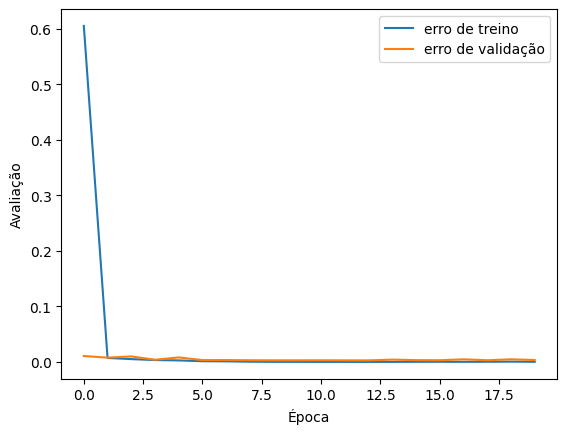

In [15]:
plt.plot(hist.epoch, hist.history['loss'], label='erro de treino');
plt.plot(hist.epoch, hist.history['val_loss'], label='erro de validação');
plt.xlabel('Época');
plt.ylabel('Avaliação');
plt.legend();

### E se meu preditor é ruim?

Você pode tentar melhorar a qualidade do seu preditor:

1. Aumentanto a quantidade de camadas da rede
2. Aumentando o número de épocas de treino
3. Aumentando o tamanho do _minibatch_
4. Modificando o algoritmo de aprendizado (RMSProp é outro algoritmo comumente utilizado)
5. Usando uma arquitetura de rede convolucional (como veremos na próxima atividade)

## Teste sua rede

Antes de anunciarmos o problema como resolvido, precisamos nos assegurar que os resultados serão replicados em  dados futuros. Para isso vamos medir a qualidade do modelo no conjunto de teste que separamos. Esse conjunto só deve ser usado uma vez que decidimos por uma arquitetura de rede e por valores dos hiperparâmetros (algoritmo de otmizição e seus parâmetros), e que treinamos a rede no conjunto de treino.

In [16]:
# Calcular erro médio no conjunto de teste
#Xt = (X_teste.reshape(X_teste.shape[0], X_teste[0].size)/255).astype('float32')

y_pred = modelo.predict(X_teste).flatten() 
mse = ((y_pred - y_teste)**2).sum()/y_pred.size
print('MSE:', mse)

24/24 [==============================] - 0s 16ms/step
MSE: 0.003207846800018876


Você deve observar se o erro médio no conjunto de teste é similar ao observado no conjunto de validação e no de treino. Uma forma mais rigorosa de atestar semelhança seria construindo intervalos de confiança para os estimadores. Nessa atividade vamos nos satisfazer com uma análise qualitativa subjetiva apenas.

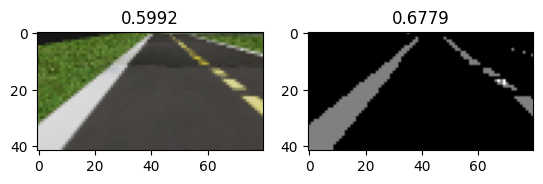

In [17]:
k = 505 # índice de exemplo -- mude para ver outro caso
fig, ax = plt.subplots(1,2)
ax[0].imshow(images[id_teste[k]]); 
ax[0].set_title(f'{y_teste[k]:.4f}');
ax[1].imshow(X_teste[k,:,:,0] + X_teste[k,:,:,1], cmap='gray'); # combinamos os canais por simplicidade
ax[1].set_title(f'{y_pred[k]:.4f}');

## Salve seu modelo

se quiser, pode salvar o modelo para usá-lo no futuro.

In [18]:
modelo.save('mlp_lane_pose_estimation.h5')

/home/pato/Documents/kaiky/duckievillage/.venv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
